# Load Data

In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import notebook
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train,_),(x_val,_) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
data = np.vstack([x_train, x_val])

In [ ]:
data = (data.astype('float32') - 127.5) / 127.5

In [ ]:
data = data.reshape(-1,784)

In [ ]:
adam = Adam(learning_rate= 0.0002, beta_1= 0.5)

# Build model

In [ ]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model, Sequential

In [ ]:
def generator(dim_noise = 100):
    input = Input(dim_noise)
    x = Dense(7 * 7 * 256, use_bias = False)(input)
    x = BatchNormalization()(x)
    x = Reshape((7,7,256))(x)
    
    x = Conv2DTranspose(128, kernel_size= (3,3), strides= 2, padding= 'same')(x) # 14
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, kernel_size= (4,4), strides= 2, padding= 'same')(x) # 28
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(1, kernel_size= (5,5), strides= 1, padding= 'same', activation= 'tanh')(x)
    x = Flatten()(x)
    return Model(input, x, name = 'generator_model')

def discriminator():
    input = Input(shape = (28 * 28))
    x = Reshape((28,28,1))(input)
    x = Conv2D(256, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(512, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14
    x = LeakyReLU(0.2)(x)
     
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    return Model(input, x, name = 'discriminator')
g = generator()
d = discriminator()

g.compile(loss= 'binary_crossentropy', optimizer = adam, metrics = ['acc'])
d.compile(loss= 'binary_crossentropy', optimizer = adam, metrics = ['acc'])

d.trainable = False

gan_model = Sequential([g, d])
gan_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
gan_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_model (Functional  (None, 784)              1733121   
 )                                                               
                                                                 
 discriminator (Functional)  (None, 1)                 3309057   
                                                                 
Total params: 5,042,178
Trainable params: 1,707,649
Non-trainable params: 3,334,529
_________________________________________________________________


In [ ]:
def show_example(gan_model):
    noise = np.random.normal(size = (10,100))
    image_generate = gan_model.layers[0](noise).numpy().reshape(-1,28,28)
    plt.figure(figsize= (12,2))
    for i in range(10):
        plt.subplot(1,10,i + 1)
        plt.imshow(image_generate[i], interpolation='nearest', cmap='gray_r' )
        plt.axis('off')
    plt.show()

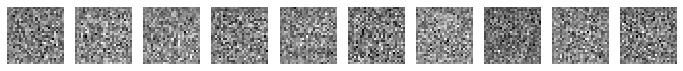

In [ ]:
# test code
show_example(gan_model)

# Train

In [ ]:
Loss_g, Loss_d = [], []
def train(gan_model, image, batch_size = 128, epochs = 200, verbose = 1):
    interation = int(len(image) / batch_size)
    for i in notebook.tqdm(range(1, epochs + 1)):
        if i % verbose == 0:
            print(f'Epochs {i}: ', end= '')
        indexes = np.arange(len(image))
        indexes = shuffle(indexes)
        fake_acc, real_acc = [], []
        loss_D, loss_G = [], []
        for j in notebook.tqdm(range(interation)):
            index = indexes[j * batch_size : (j + 1) * batch_size]
            real_img = np.array([image[k] for k in index])
            
            # sinh ảnh từ noise
            noise = np.random.normal(size = (batch_size, 100))
            fake_img = gan_model.layers[0](noise)
        
            # nhiễu label
            y = np.ones(batch_size * 2)
            y[:batch_size] = 0.9 # real_img
            y[batch_size:] = 0.1 # fake_img
            # train discriminator
            gan_model.layers[1].trainable = True
            # train real_img
            loss_real = gan_model.layers[1].train_on_batch(real_img,y[:batch_size])
            loss_fake = gan_model.layers[1].train_on_batch(fake_img,y[batch_size:])
            
            loss_d = 0.5 * np.add(loss_real, loss_fake)
            
            loss_D.append(loss_d)
            
            fake_acc.append(loss_fake[1])
            real_acc.append(loss_real[1])
            # train generator
            fake_img = np.random.normal(size = (batch_size, 100))
            y_fake = np.ones(batch_size)
            gan_model.layers[1].trainable = False
            loss_g = gan_model.train_on_batch(fake_img,y_fake)
            loss_G.append(loss_g)

        if i % verbose == 0:
            show_example(gan_model)
            print('d_loss: %f   g_loss: %f  | acc_real: %.2f    acc_fake: %.2f' % (np.array(loss_D).mean(), np.array(loss_G).mean(),np.array(real_acc).mean(), np.array(fake_acc).mean()))
            Loss_d.append(np.array(loss_D).mean())
            Loss_g.append(np.array(loss_G).mean())

  0%|          | 0/200 [00:00<?, ?it/s]

Epochs 1: 

  0%|          | 0/546 [00:00<?, ?it/s]

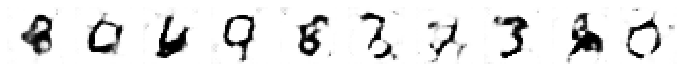

d_loss: 0.279906   g_loss: 0.624999  | acc_real: 0.00    acc_fake: 0.00
Epochs 2: 

  0%|          | 0/546 [00:00<?, ?it/s]

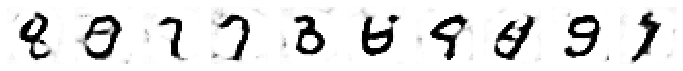

d_loss: 0.332273   g_loss: 0.542114  | acc_real: 0.00    acc_fake: 0.00
Epochs 3: 

  0%|          | 0/546 [00:00<?, ?it/s]

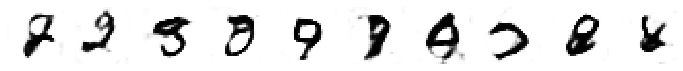

d_loss: 0.325871   g_loss: 0.545337  | acc_real: 0.00    acc_fake: 0.00
Epochs 4: 

  0%|          | 0/546 [00:00<?, ?it/s]

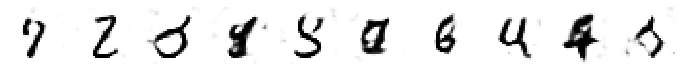

d_loss: 0.322293   g_loss: 0.573019  | acc_real: 0.00    acc_fake: 0.00
Epochs 5: 

  0%|          | 0/546 [00:00<?, ?it/s]

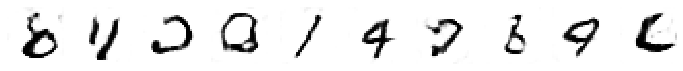

d_loss: 0.321289   g_loss: 0.587059  | acc_real: 0.00    acc_fake: 0.00
Epochs 6: 

  0%|          | 0/546 [00:00<?, ?it/s]

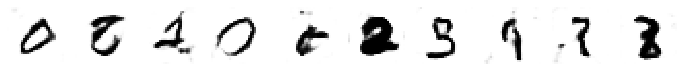

d_loss: 0.320857   g_loss: 0.597983  | acc_real: 0.00    acc_fake: 0.00
Epochs 7: 

  0%|          | 0/546 [00:00<?, ?it/s]

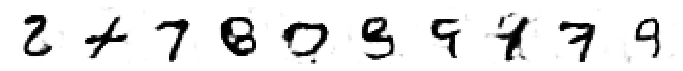

d_loss: 0.320524   g_loss: 0.605394  | acc_real: 0.00    acc_fake: 0.00
Epochs 8: 

  0%|          | 0/546 [00:00<?, ?it/s]

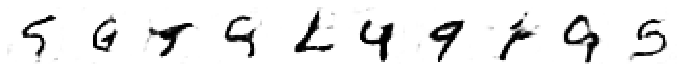

d_loss: 0.319442   g_loss: 0.609233  | acc_real: 0.00    acc_fake: 0.00
Epochs 9: 

  0%|          | 0/546 [00:00<?, ?it/s]

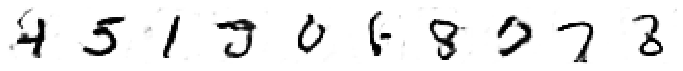

d_loss: 0.318502   g_loss: 0.615042  | acc_real: 0.00    acc_fake: 0.00
Epochs 10: 

  0%|          | 0/546 [00:00<?, ?it/s]

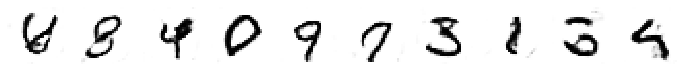

d_loss: 0.317932   g_loss: 0.618897  | acc_real: 0.00    acc_fake: 0.00
Epochs 11: 

  0%|          | 0/546 [00:00<?, ?it/s]

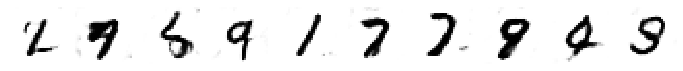

d_loss: 0.316802   g_loss: 0.623557  | acc_real: 0.00    acc_fake: 0.00
Epochs 12: 

  0%|          | 0/546 [00:00<?, ?it/s]

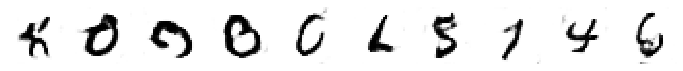

d_loss: 0.315345   g_loss: 0.629993  | acc_real: 0.00    acc_fake: 0.00
Epochs 13: 

  0%|          | 0/546 [00:00<?, ?it/s]

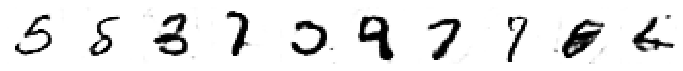

d_loss: 0.314765   g_loss: 0.635150  | acc_real: 0.00    acc_fake: 0.00
Epochs 14: 

  0%|          | 0/546 [00:00<?, ?it/s]

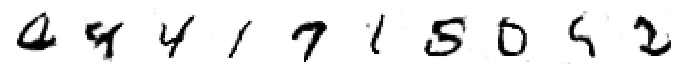

d_loss: 0.313815   g_loss: 0.639015  | acc_real: 0.00    acc_fake: 0.00
Epochs 15: 

  0%|          | 0/546 [00:00<?, ?it/s]

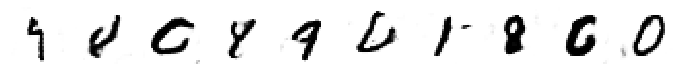

d_loss: 0.312977   g_loss: 0.641468  | acc_real: 0.00    acc_fake: 0.00
Epochs 16: 

  0%|          | 0/546 [00:00<?, ?it/s]

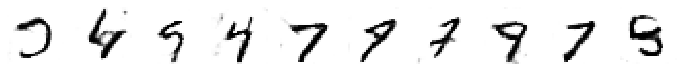

d_loss: 0.313014   g_loss: 0.645649  | acc_real: 0.00    acc_fake: 0.00
Epochs 17: 

  0%|          | 0/546 [00:00<?, ?it/s]

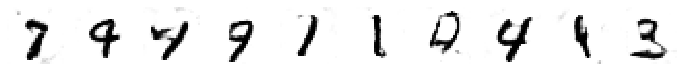

d_loss: 0.311981   g_loss: 0.648270  | acc_real: 0.00    acc_fake: 0.00
Epochs 18: 

  0%|          | 0/546 [00:00<?, ?it/s]

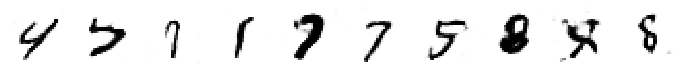

d_loss: 0.311044   g_loss: 0.652324  | acc_real: 0.00    acc_fake: 0.00
Epochs 19: 

  0%|          | 0/546 [00:00<?, ?it/s]

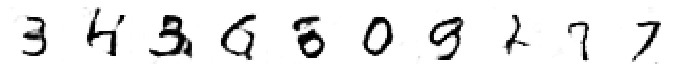

d_loss: 0.311646   g_loss: 0.652444  | acc_real: 0.00    acc_fake: 0.00
Epochs 20: 

  0%|          | 0/546 [00:00<?, ?it/s]

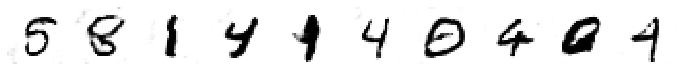

d_loss: 0.310860   g_loss: 0.654222  | acc_real: 0.00    acc_fake: 0.00
Epochs 21: 

  0%|          | 0/546 [00:00<?, ?it/s]

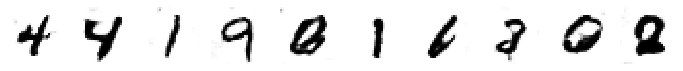

d_loss: 0.310560   g_loss: 0.657301  | acc_real: 0.00    acc_fake: 0.00
Epochs 22: 

  0%|          | 0/546 [00:00<?, ?it/s]

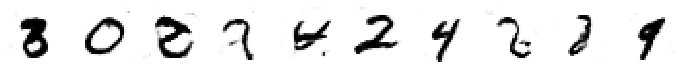

d_loss: 0.309428   g_loss: 0.659642  | acc_real: 0.00    acc_fake: 0.00
Epochs 23: 

  0%|          | 0/546 [00:00<?, ?it/s]

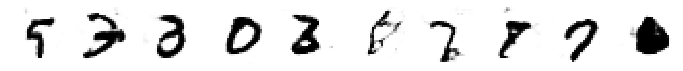

d_loss: 0.309704   g_loss: 0.661129  | acc_real: 0.00    acc_fake: 0.00
Epochs 24: 

  0%|          | 0/546 [00:00<?, ?it/s]

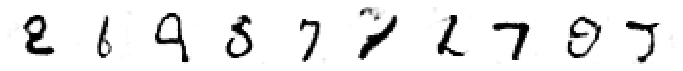

d_loss: 0.309074   g_loss: 0.662831  | acc_real: 0.00    acc_fake: 0.00
Epochs 25: 

  0%|          | 0/546 [00:00<?, ?it/s]

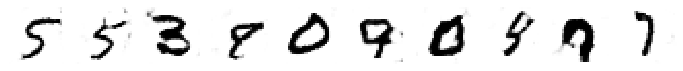

d_loss: 0.308071   g_loss: 0.665930  | acc_real: 0.00    acc_fake: 0.00
Epochs 26: 

  0%|          | 0/546 [00:00<?, ?it/s]

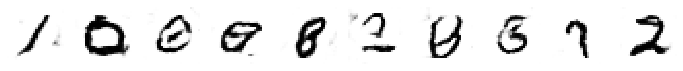

d_loss: 0.308054   g_loss: 0.668702  | acc_real: 0.00    acc_fake: 0.00
Epochs 27: 

  0%|          | 0/546 [00:00<?, ?it/s]

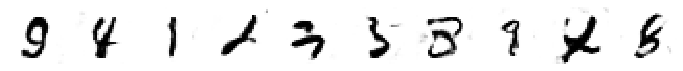

d_loss: 0.307501   g_loss: 0.668832  | acc_real: 0.00    acc_fake: 0.00
Epochs 28: 

  0%|          | 0/546 [00:00<?, ?it/s]

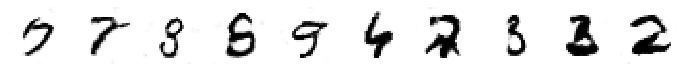

d_loss: 0.307833   g_loss: 0.670573  | acc_real: 0.00    acc_fake: 0.00
Epochs 29: 

  0%|          | 0/546 [00:00<?, ?it/s]

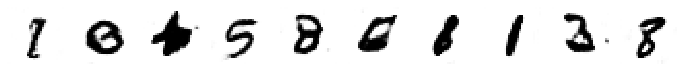

d_loss: 0.307158   g_loss: 0.671530  | acc_real: 0.00    acc_fake: 0.00
Epochs 30: 

  0%|          | 0/546 [00:00<?, ?it/s]

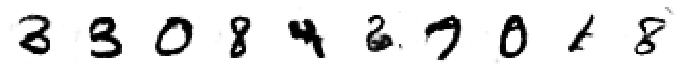

d_loss: 0.306542   g_loss: 0.672867  | acc_real: 0.00    acc_fake: 0.00
Epochs 31: 

  0%|          | 0/546 [00:00<?, ?it/s]

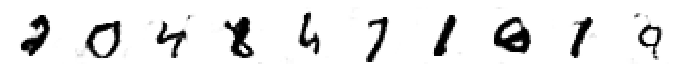

d_loss: 0.306360   g_loss: 0.674035  | acc_real: 0.00    acc_fake: 0.00
Epochs 32: 

  0%|          | 0/546 [00:00<?, ?it/s]

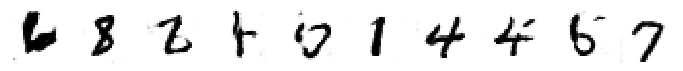

d_loss: 0.305997   g_loss: 0.674662  | acc_real: 0.00    acc_fake: 0.00
Epochs 33: 

  0%|          | 0/546 [00:00<?, ?it/s]

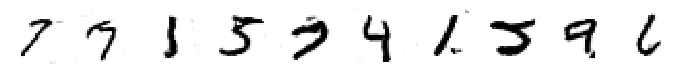

d_loss: 0.305663   g_loss: 0.676382  | acc_real: 0.00    acc_fake: 0.00
Epochs 34: 

  0%|          | 0/546 [00:00<?, ?it/s]

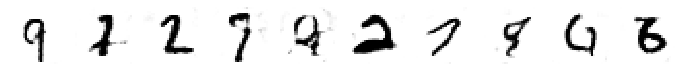

d_loss: 0.305156   g_loss: 0.677757  | acc_real: 0.00    acc_fake: 0.00
Epochs 35: 

  0%|          | 0/546 [00:00<?, ?it/s]

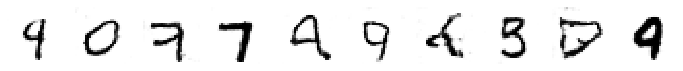

d_loss: 0.305326   g_loss: 0.679447  | acc_real: 0.00    acc_fake: 0.00
Epochs 36: 

  0%|          | 0/546 [00:00<?, ?it/s]

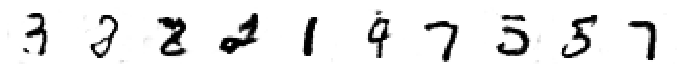

d_loss: 0.305046   g_loss: 0.680983  | acc_real: 0.00    acc_fake: 0.00
Epochs 37: 

  0%|          | 0/546 [00:00<?, ?it/s]

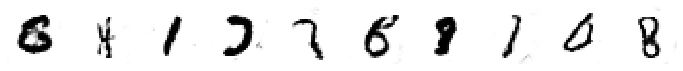

d_loss: 0.304881   g_loss: 0.680409  | acc_real: 0.00    acc_fake: 0.00
Epochs 38: 

  0%|          | 0/546 [00:00<?, ?it/s]

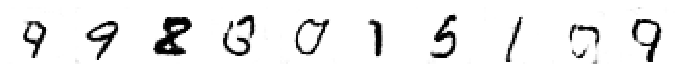

d_loss: 0.303896   g_loss: 0.680383  | acc_real: 0.00    acc_fake: 0.00
Epochs 39: 

  0%|          | 0/546 [00:00<?, ?it/s]

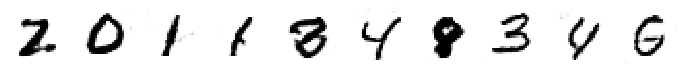

d_loss: 0.303942   g_loss: 0.685505  | acc_real: 0.00    acc_fake: 0.00
Epochs 40: 

  0%|          | 0/546 [00:00<?, ?it/s]

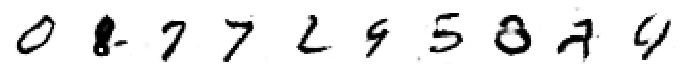

d_loss: 0.303185   g_loss: 0.684790  | acc_real: 0.00    acc_fake: 0.00
Epochs 41: 

  0%|          | 0/546 [00:00<?, ?it/s]

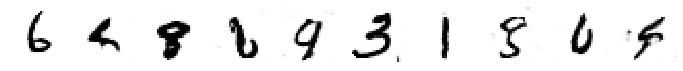

d_loss: 0.303327   g_loss: 0.685071  | acc_real: 0.00    acc_fake: 0.00
Epochs 42: 

  0%|          | 0/546 [00:00<?, ?it/s]

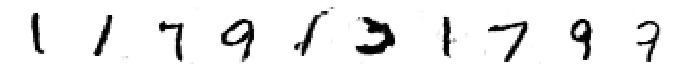

d_loss: 0.302808   g_loss: 0.686753  | acc_real: 0.00    acc_fake: 0.00
Epochs 43: 

  0%|          | 0/546 [00:00<?, ?it/s]

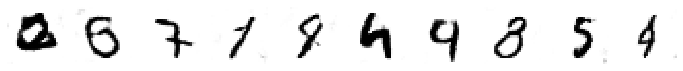

d_loss: 0.303113   g_loss: 0.687006  | acc_real: 0.00    acc_fake: 0.00
Epochs 44: 

  0%|          | 0/546 [00:00<?, ?it/s]

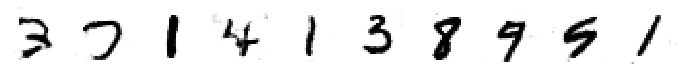

d_loss: 0.302433   g_loss: 0.690989  | acc_real: 0.00    acc_fake: 0.00
Epochs 45: 

  0%|          | 0/546 [00:00<?, ?it/s]

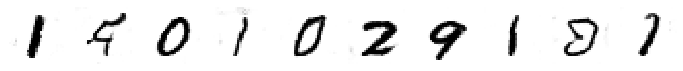

d_loss: 0.302040   g_loss: 0.692260  | acc_real: 0.00    acc_fake: 0.00
Epochs 46: 

  0%|          | 0/546 [00:00<?, ?it/s]

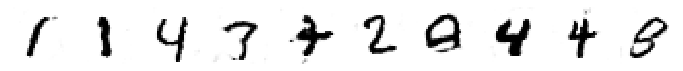

d_loss: 0.301951   g_loss: 0.691956  | acc_real: 0.00    acc_fake: 0.00
Epochs 47: 

  0%|          | 0/546 [00:00<?, ?it/s]

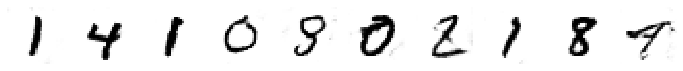

d_loss: 0.301429   g_loss: 0.694925  | acc_real: 0.00    acc_fake: 0.00
Epochs 48: 

  0%|          | 0/546 [00:00<?, ?it/s]

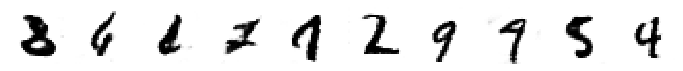

d_loss: 0.301186   g_loss: 0.695314  | acc_real: 0.00    acc_fake: 0.00
Epochs 49: 

  0%|          | 0/546 [00:00<?, ?it/s]

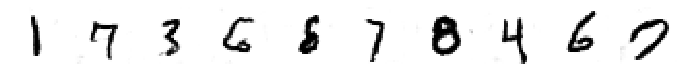

d_loss: 0.300800   g_loss: 0.696229  | acc_real: 0.00    acc_fake: 0.00
Epochs 50: 

  0%|          | 0/546 [00:00<?, ?it/s]

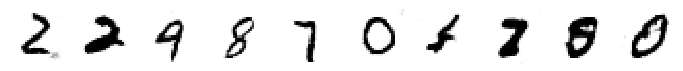

d_loss: 0.300925   g_loss: 0.698468  | acc_real: 0.00    acc_fake: 0.00
Epochs 51: 

  0%|          | 0/546 [00:00<?, ?it/s]

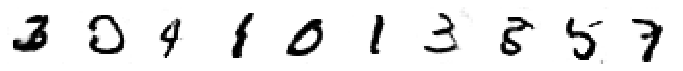

d_loss: 0.300968   g_loss: 0.697796  | acc_real: 0.00    acc_fake: 0.00
Epochs 52: 

  0%|          | 0/546 [00:00<?, ?it/s]

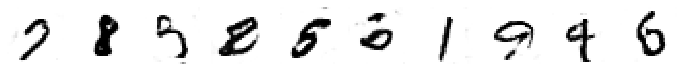

d_loss: 0.300507   g_loss: 0.695060  | acc_real: 0.00    acc_fake: 0.00
Epochs 53: 

  0%|          | 0/546 [00:00<?, ?it/s]

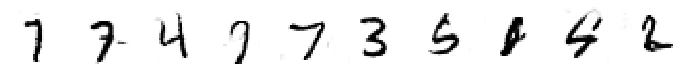

d_loss: 0.300179   g_loss: 0.698814  | acc_real: 0.00    acc_fake: 0.00
Epochs 54: 

  0%|          | 0/546 [00:00<?, ?it/s]

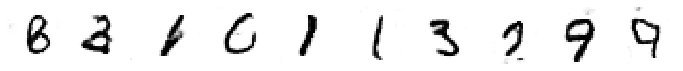

d_loss: 0.300540   g_loss: 0.701062  | acc_real: 0.00    acc_fake: 0.00
Epochs 55: 

  0%|          | 0/546 [00:00<?, ?it/s]

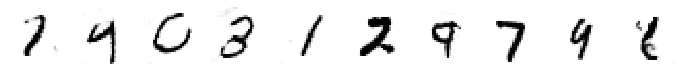

d_loss: 0.299333   g_loss: 0.700517  | acc_real: 0.00    acc_fake: 0.00
Epochs 56: 

  0%|          | 0/546 [00:00<?, ?it/s]

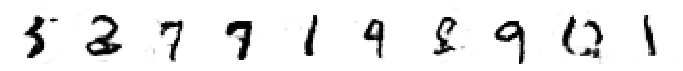

d_loss: 0.299314   g_loss: 0.702425  | acc_real: 0.00    acc_fake: 0.00
Epochs 57: 

  0%|          | 0/546 [00:00<?, ?it/s]

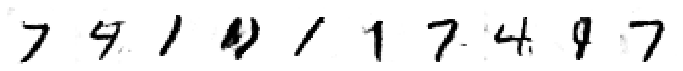

d_loss: 0.299418   g_loss: 0.702074  | acc_real: 0.00    acc_fake: 0.00
Epochs 58: 

  0%|          | 0/546 [00:00<?, ?it/s]

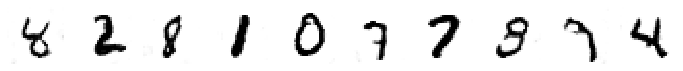

d_loss: 0.298583   g_loss: 0.701554  | acc_real: 0.00    acc_fake: 0.00
Epochs 59: 

  0%|          | 0/546 [00:00<?, ?it/s]

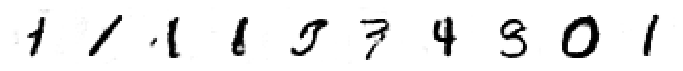

d_loss: 0.299034   g_loss: 0.704851  | acc_real: 0.00    acc_fake: 0.00
Epochs 60: 

  0%|          | 0/546 [00:00<?, ?it/s]

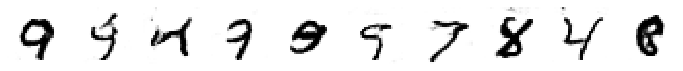

d_loss: 0.298997   g_loss: 0.703731  | acc_real: 0.00    acc_fake: 0.00
Epochs 61: 

  0%|          | 0/546 [00:00<?, ?it/s]

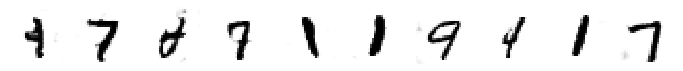

d_loss: 0.298254   g_loss: 0.706089  | acc_real: 0.00    acc_fake: 0.00
Epochs 62: 

  0%|          | 0/546 [00:00<?, ?it/s]

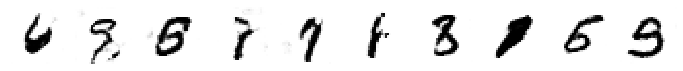

d_loss: 0.298235   g_loss: 0.707053  | acc_real: 0.00    acc_fake: 0.00
Epochs 63: 

  0%|          | 0/546 [00:00<?, ?it/s]

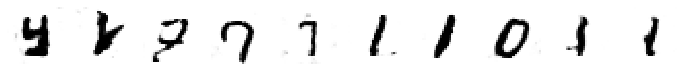

d_loss: 0.297332   g_loss: 0.708799  | acc_real: 0.00    acc_fake: 0.00
Epochs 64: 

  0%|          | 0/546 [00:00<?, ?it/s]

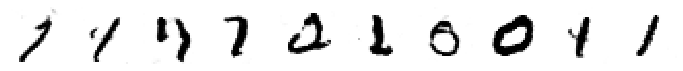

d_loss: 0.298202   g_loss: 0.706236  | acc_real: 0.00    acc_fake: 0.00
Epochs 65: 

  0%|          | 0/546 [00:00<?, ?it/s]

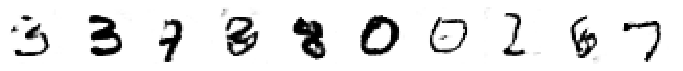

d_loss: 0.296959   g_loss: 0.709124  | acc_real: 0.00    acc_fake: 0.00
Epochs 66: 

  0%|          | 0/546 [00:00<?, ?it/s]

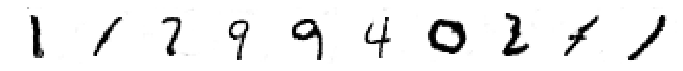

d_loss: 0.297176   g_loss: 0.710424  | acc_real: 0.00    acc_fake: 0.00
Epochs 67: 

  0%|          | 0/546 [00:00<?, ?it/s]

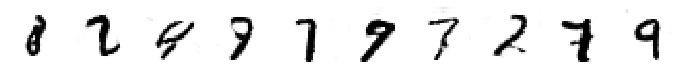

d_loss: 0.296847   g_loss: 0.713906  | acc_real: 0.00    acc_fake: 0.00
Epochs 68: 

  0%|          | 0/546 [00:00<?, ?it/s]

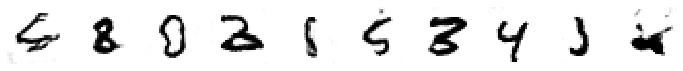

d_loss: 0.296807   g_loss: 0.711043  | acc_real: 0.00    acc_fake: 0.00
Epochs 69: 

  0%|          | 0/546 [00:00<?, ?it/s]

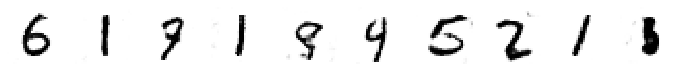

d_loss: 0.296244   g_loss: 0.714481  | acc_real: 0.00    acc_fake: 0.00
Epochs 70: 

  0%|          | 0/546 [00:00<?, ?it/s]

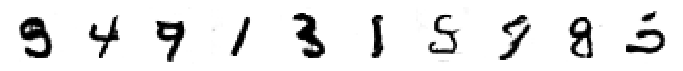

d_loss: 0.296750   g_loss: 0.711918  | acc_real: 0.00    acc_fake: 0.00
Epochs 71: 

  0%|          | 0/546 [00:00<?, ?it/s]

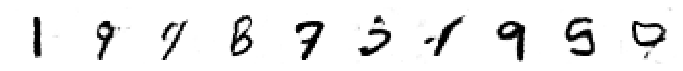

d_loss: 0.296203   g_loss: 0.716173  | acc_real: 0.00    acc_fake: 0.00
Epochs 72: 

  0%|          | 0/546 [00:00<?, ?it/s]

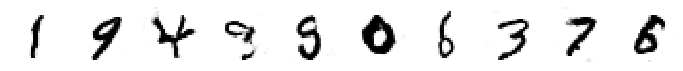

d_loss: 0.296352   g_loss: 0.714707  | acc_real: 0.00    acc_fake: 0.00
Epochs 73: 

  0%|          | 0/546 [00:00<?, ?it/s]

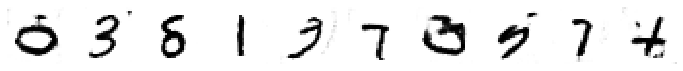

d_loss: 0.295777   g_loss: 0.716574  | acc_real: 0.00    acc_fake: 0.00
Epochs 74: 

  0%|          | 0/546 [00:00<?, ?it/s]

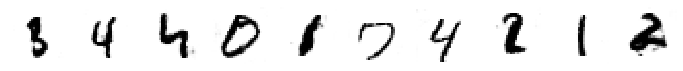

d_loss: 0.295230   g_loss: 0.716444  | acc_real: 0.00    acc_fake: 0.00
Epochs 75: 

  0%|          | 0/546 [00:00<?, ?it/s]

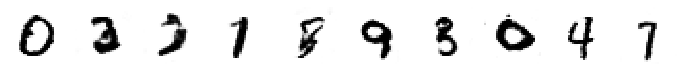

d_loss: 0.294769   g_loss: 0.720180  | acc_real: 0.00    acc_fake: 0.00
Epochs 76: 

  0%|          | 0/546 [00:00<?, ?it/s]

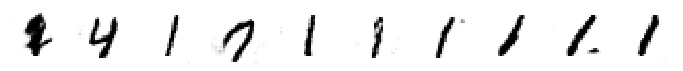

d_loss: 0.294436   g_loss: 0.718777  | acc_real: 0.00    acc_fake: 0.00
Epochs 77: 

  0%|          | 0/546 [00:00<?, ?it/s]

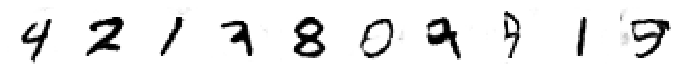

d_loss: 0.294303   g_loss: 0.721411  | acc_real: 0.00    acc_fake: 0.00
Epochs 78: 

  0%|          | 0/546 [00:00<?, ?it/s]

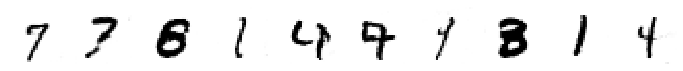

d_loss: 0.294271   g_loss: 0.722891  | acc_real: 0.00    acc_fake: 0.00
Epochs 79: 

  0%|          | 0/546 [00:00<?, ?it/s]

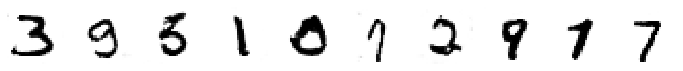

d_loss: 0.294139   g_loss: 0.722268  | acc_real: 0.00    acc_fake: 0.00
Epochs 80: 

  0%|          | 0/546 [00:00<?, ?it/s]

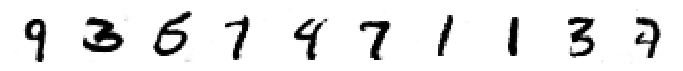

d_loss: 0.294199   g_loss: 0.723758  | acc_real: 0.00    acc_fake: 0.00
Epochs 81: 

  0%|          | 0/546 [00:00<?, ?it/s]

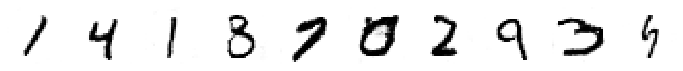

d_loss: 0.293347   g_loss: 0.722837  | acc_real: 0.00    acc_fake: 0.00
Epochs 82: 

  0%|          | 0/546 [00:00<?, ?it/s]

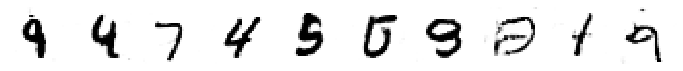

d_loss: 0.293033   g_loss: 0.725259  | acc_real: 0.00    acc_fake: 0.00
Epochs 83: 

  0%|          | 0/546 [00:00<?, ?it/s]

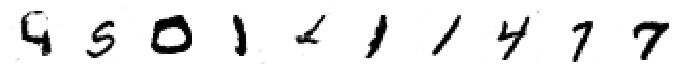

d_loss: 0.293424   g_loss: 0.727303  | acc_real: 0.00    acc_fake: 0.00
Epochs 84: 

  0%|          | 0/546 [00:00<?, ?it/s]

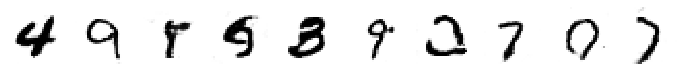

d_loss: 0.292358   g_loss: 0.726745  | acc_real: 0.00    acc_fake: 0.00
Epochs 85: 

  0%|          | 0/546 [00:00<?, ?it/s]

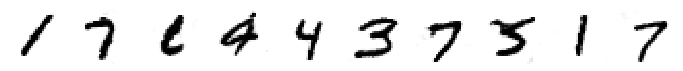

d_loss: 0.292295   g_loss: 0.728385  | acc_real: 0.00    acc_fake: 0.00
Epochs 86: 

  0%|          | 0/546 [00:00<?, ?it/s]

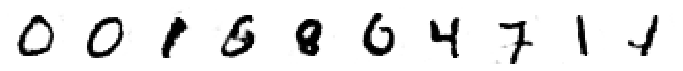

d_loss: 0.292176   g_loss: 0.728724  | acc_real: 0.00    acc_fake: 0.00
Epochs 87: 

  0%|          | 0/546 [00:00<?, ?it/s]

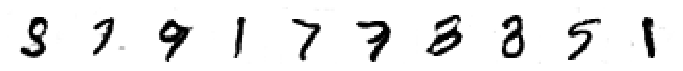

d_loss: 0.291939   g_loss: 0.729154  | acc_real: 0.00    acc_fake: 0.00
Epochs 88: 

  0%|          | 0/546 [00:00<?, ?it/s]

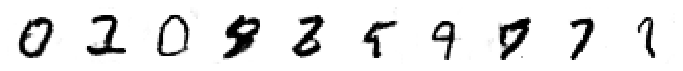

d_loss: 0.292022   g_loss: 0.730463  | acc_real: 0.00    acc_fake: 0.00
Epochs 89: 

  0%|          | 0/546 [00:00<?, ?it/s]

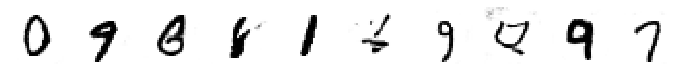

d_loss: 0.292052   g_loss: 0.729834  | acc_real: 0.00    acc_fake: 0.00
Epochs 90: 

  0%|          | 0/546 [00:00<?, ?it/s]

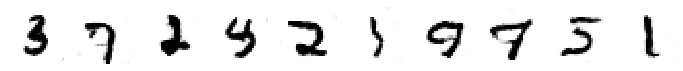

d_loss: 0.292101   g_loss: 0.732015  | acc_real: 0.00    acc_fake: 0.00
Epochs 91: 

  0%|          | 0/546 [00:00<?, ?it/s]

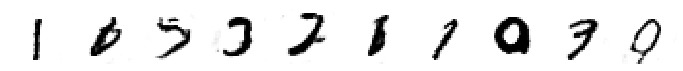

d_loss: 0.290835   g_loss: 0.733416  | acc_real: 0.00    acc_fake: 0.00
Epochs 92: 

  0%|          | 0/546 [00:00<?, ?it/s]

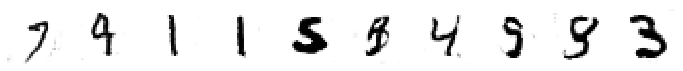

d_loss: 0.290789   g_loss: 0.735823  | acc_real: 0.00    acc_fake: 0.00
Epochs 93: 

  0%|          | 0/546 [00:00<?, ?it/s]

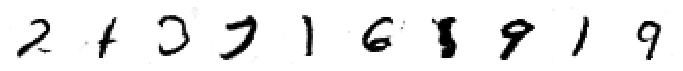

d_loss: 0.290091   g_loss: 0.736239  | acc_real: 0.00    acc_fake: 0.00
Epochs 94: 

  0%|          | 0/546 [00:00<?, ?it/s]

In [ ]:
train(gan_model, data)

In [ ]:
show_example(gan_model)